In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Load the data set, and check for missing values

In [3]:
policies = pd.read_csv('/content/policies.csv')
policies.head()

,policy_id,customer_id,customer_age,customer_gender,marital_status,num_dependents,country,income_band,product_type,coverage_amount,...,critical_illness_rider,disability_rider,late_payment_count,customer_service_calls,beneficiary_updated,premium_change_pct,churned,churn_reason,snapshot_date,data_version
0,P000000,C000860,29,M,Married,0,US,Low,Universal,163000.0,...,False,False,0,1,True,-0.02,False,NaN,2024-06-30,v1.0
1,P000001,C001294,47,F,Married,1,DE,Ultra,Term,62000.0,...,False,False,0,1,False,-0.08,False,NaN,2024-06-30,v1.0
2,P000002,C001130,57,M,Single,0,DE,Mid,Universal,196000.0,...,False,False,1,0,False,0.14,False,NaN,2024-06-30,v1.0
3,P000003,C001095,29,F,Single,3,FR,Low,Universal,140000.0,...,False,False,2,1,False,0.01,False,NaN,2024-06-30,v1.0
4,P000004,C001638,47,F,Divorced,3,FR,NaN,Whole,333000.0,...,False,False,1,0,False,0.06,False,NaN,2024-06-30,v1.0


In [4]:
# look for statistics and missing values
print(policies.describe())
print(policies.info())

       customer_age  num_dependents  coverage_amount      premium  \
count   6000.000000     6000.000000     6.000000e+03  6000.000000   
mean      44.408833        1.178000     2.130965e+05   207.732770   
std       12.022705        1.073239     1.713029e+05   199.602361   
min       18.000000        0.000000     1.100000e+04     7.830000   
25%       36.000000        0.000000     1.030000e+05    85.267500   
50%       44.000000        1.000000     1.640000e+05   147.760000   
75%       53.000000        2.000000     2.670000e+05   256.035000   
max       85.000000        5.000000     1.893000e+06  2346.560000   

       tenure_months  renewal_count  discount_rate   num_riders  \
count    6000.000000    6000.000000    1496.000000  6000.000000   
mean       83.795333       6.526833       0.148295     0.638333   
std        49.101286       4.101636       0.058574     1.093189   
min         1.000000       0.000000       0.050000     0.000000   
25%        42.000000       3.000000       0

In [39]:
# check if the id is unique, how many different customers we have
print(policies['policy_id'].nunique())
print(policies['customer_id'].nunique())

6000
2569
0       175
1       112
2       117
3        22
4        87
       ... 
5995     53
5996     84
5997     31
5998     49
5999     84
Name: tenure_months, Length: 6000, dtype: int64


In [5]:
# convert to dates and ensure the end date is always after start date
policies['policy_start_date'] = pd.to_datetime(policies['policy_start_date'])
policies['snapshot_date'] = pd.to_datetime(policies['snapshot_date'])
policies['policy_end_date'] = pd.to_datetime(policies['policy_end_date'])

duration = policies['policy_end_date'] - policies['policy_start_date']

# end_date alwasys > start date when have
print(duration.dropna().min())

180 days 00:00:00


In [6]:
# tenure months is not perfect - but we can manage  as a prox!
# but also - see that the end date is projected - we dont know if the customers
# will reach that end date (year 2028 for example)
policies['calculated_months'] = (
    (policies['policy_end_date'].dt.year - policies['policy_start_date'].dt.year) * 12 +
    (policies['policy_end_date'].dt.month - policies['policy_start_date'].dt.month)
)
policies[~policies['policy_end_date'].isna()][['policy_start_date', 'policy_end_date', 'tenure_months', 'calculated_months']]

,policy_start_date,policy_end_date,tenure_months,calculated_months
5,2018-02-13,2021-09-25,44,43.0
6,2020-09-14,2028-04-05,92,91.0
11,2018-07-16,2027-06-29,109,107.0
25,2022-02-12,2026-05-22,52,51.0
27,2014-07-31,2015-11-23,16,16.0
...,...,...,...,...
5971,2014-07-08,2015-10-01,15,15.0
5979,2020-03-01,2020-08-28,6,5.0
5985,2020-05-18,2021-04-13,11,11.0
5997,2011-11-17,2014-06-04,31,31.0


In [9]:
# have True with 0 - a bit weird
print(policies[['has_rider', 'num_riders']].drop_duplicates())
print(f'Num of records where num riders = 0 when has rider flag is true: {policies[(policies['has_rider'] == True) & (policies['num_riders'] == 0)].shape[0]}')

      has_rider  num_riders
0         False           0
4          True           0
6          True           1
16         True           4
18         True           3
34         True           2
125       False           2
327        True           7
366       False           3
444        True           5
543       False           1
720        True           6
2358      False           5
2773      False           4
Num of records where num riders = 0 when has rider flag is true: 599


In [7]:
print(policies['snapshot_date'].unique())
print(f'there are {policies[(policies['churned'] == False) & (policies['churn_reason'].isna() == False)].shape[0]} reason for churn with a false flag')

<DatetimeArray>
['2024-06-30 00:00:00']
Length: 1, dtype: datetime64[ns]
there are 0 reason for churn with a false flag


In [8]:
policies[['policy_start_date', 'policy_end_date', 'customer_id', 'premium', 'renewal_count', 'premium_change_pct']].sort_values(by = 'customer_id').iloc[0:60]

,policy_start_date,policy_end_date,customer_id,premium,renewal_count,premium_change_pct
3395,2021-05-01,2030-08-12,C000000,106.42,9,0.02
1988,2019-08-12,NaT,C000001,121.23,4,0.07
206,2013-03-15,NaT,C000001,78.53,11,-0.01
2221,2019-08-25,2020-12-17,C000001,408.39,1,0.13
1861,2015-07-15,2019-08-23,C000001,303.50,4,0.08
4811,2014-02-11,NaT,C000002,186.77,10,0.03
1600,2018-11-23,NaT,C000002,119.34,5,-0.08
990,2017-02-26,NaT,C000003,152.10,7,0.21
426,2016-06-01,NaT,C000004,79.66,8,0.07
986,2021-02-21,NaT,C000005,39.82,3,-0.12


Data qualities issues to notice:

1. What is the premium currency? there are multipile countries. same for the coverage amount, anything money related. We will assume it's all in one currency, being USD
2. Income Band - refereing to per country? global? how to compare? what are the criterias? - We will assume for simplicity it is global
3. the discount is empty when not taken - let's impute 0 instead!
4. end date is missing - but we have tenure lenght in months, even tho it's not perfect - we can impute it!
5. we note that the tenure and end date refer to a date that is yet to be as well
6. has rider and num riders seem to be inconssistent where the flag it true but the number is 0 - we can either fill in 1 in these records as a defaults rider number, imput the mean, or delete the rows. for simplicity, we will fill in the mean, and round it so in wont be a decimal number by chance

In [11]:
# fill 0 in the discount rate where empty
policies['discount_rate'] = policies['discount_rate'].fillna(0)

# fill in the end date based on tenure
policies['policy_end_date'] = policies.apply(
    lambda row: row['policy_start_date'] + pd.DateOffset(months=row['tenure_months'])
    if pd.isna(row['policy_end_date']) else row['policy_end_date'],
    axis=1
)

print("First 5 records with filled dates:")
print(policies[['policy_start_date', 'tenure_months', 'policy_end_date']].head())

# fill in the num riders to be the mnean like we said - mean based on has rider is true
inconsistent_mask = (policies['has_rider'] == True) & (policies['num_riders'] == 0)

mean_riders = policies[(policies['has_rider'] == True) & (policies['num_riders'] > 0)]['num_riders'].mean()

# 4. Fill in the mean (rounded to nearest whole number) for inconsistent records
# We round because you can't have 1.92 riders
policies.loc[inconsistent_mask, 'num_riders'] = round(mean_riders)

First 5 records with filled dates:
  policy_start_date  tenure_months policy_end_date
0        2010-02-04            175      2024-09-04
1        2015-04-11            112      2024-08-11
2        2014-10-26            117      2024-07-26
3        2022-08-11             22      2024-06-11
4        2017-04-30             87      2024-07-30


In [18]:
policies.columns

Index(['policy_id', 'customer_id', 'customer_age', 'customer_gender',
       'marital_status', 'num_dependents', 'country', 'income_band',
       'product_type', 'coverage_amount', 'premium', 'payment_frequency',
       'policy_start_date', 'policy_end_date', 'tenure_months',
       'renewal_count', 'acquisition_channel', 'agent_id', 'discount_applied',
       'discount_rate', 'has_rider', 'num_riders', 'critical_illness_rider',
       'disability_rider', 'late_payment_count', 'customer_service_calls',
       'beneficiary_updated', 'premium_change_pct', 'churned', 'churn_reason',
       'snapshot_date', 'data_version', 'calculated_months'],
      dtype='object')

Question 2 - analysis

In [20]:
# check if these have any correletion to churn rate
categorical_cols = ['payment_frequency', 'acquisition_channel', 'customer_gender', 'marital_status',
                    'income_band', 'country', 'product_type', 'discount_applied']

for col in categorical_cols:
    print(f'\n=== {col} ===')

    freq_table = policies.groupby(col)['churned'].agg(
        count='size',
        churn_rate='mean'
    ).sort_values('churn_rate', ascending=False)

    print(freq_table)


=== payment_frequency ===
                   count  churn_rate
payment_frequency                   
Monthly             3587    0.154725
Quarterly           1543    0.110175
Annual               870    0.077011

=== acquisition_channel ===
                     count  churn_rate
acquisition_channel                   
Bank                   875    0.155429
Employer               582    0.144330
Online                1840    0.140217
Agent                 2703    0.116167

=== customer_gender ===
                 count  churn_rate
customer_gender                   
M                 2858    0.140658
U                  255    0.137255
F                 2887    0.122965

=== marital_status ===
                count  churn_rate
marital_status                   
Single           2002    0.139361
Married          2755    0.129946
Widowed           519    0.129094
Divorced          724    0.121547

=== income_band ===
             count  churn_rate
income_band                   
High          

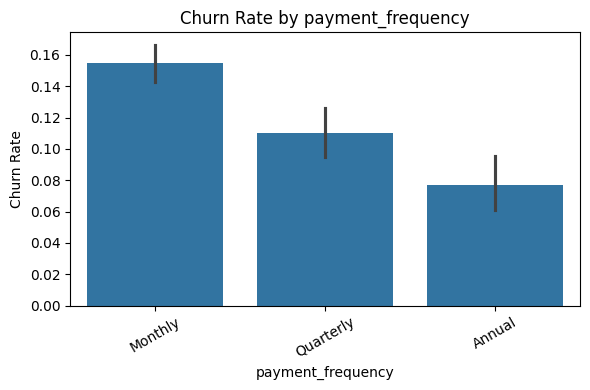

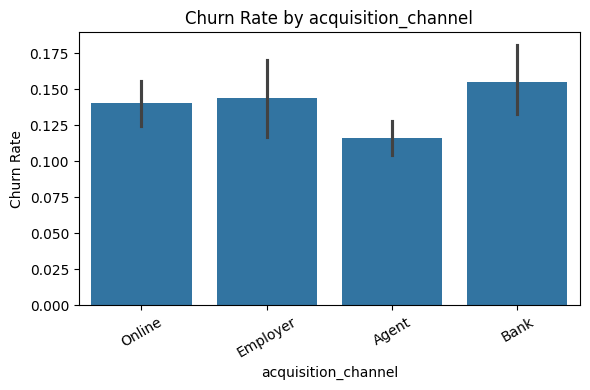

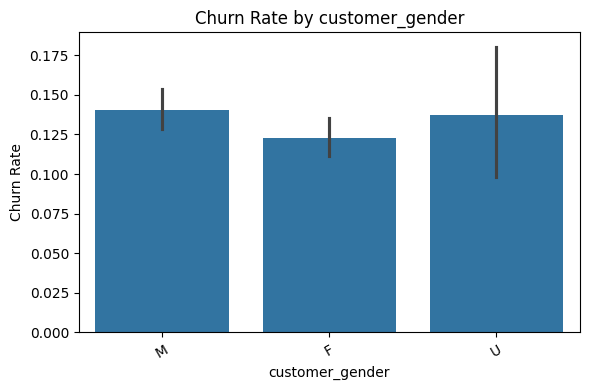

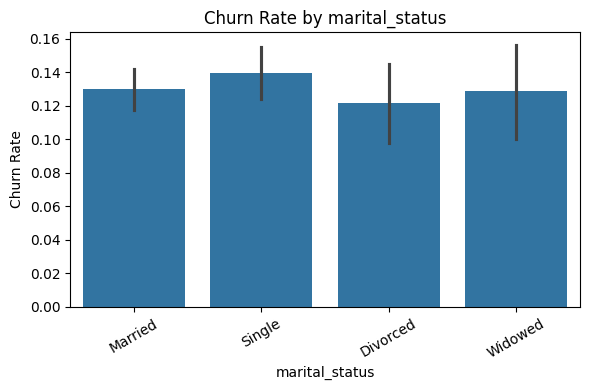

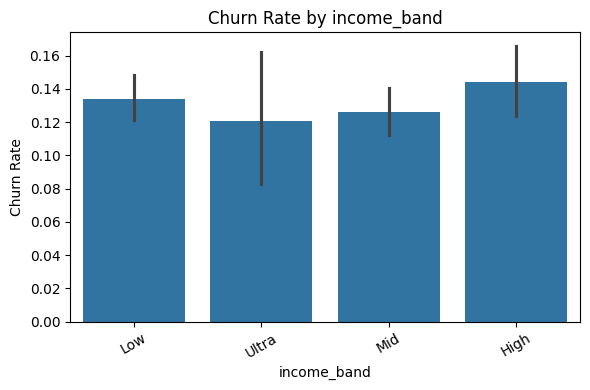

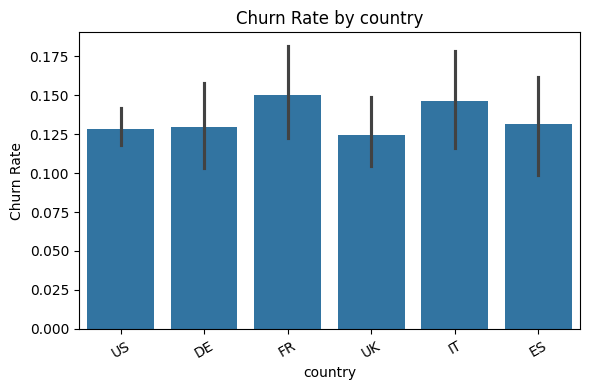

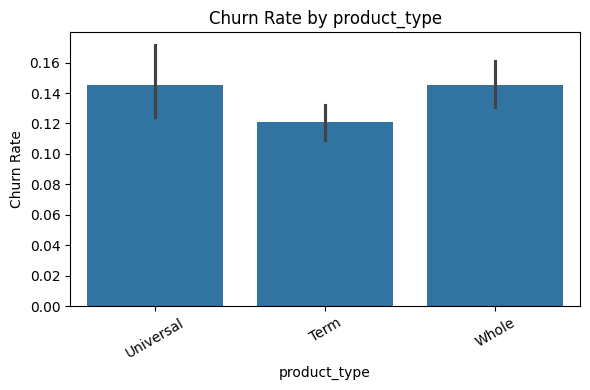

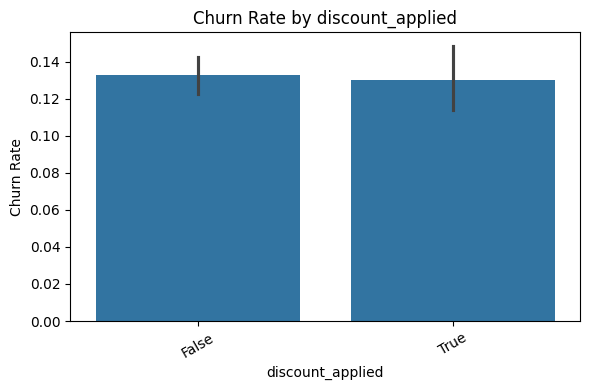

In [21]:
for col in ['payment_frequency', 'acquisition_channel', 'customer_gender', 'marital_status',
            'income_band', 'country', 'product_type', 'discount_applied']:
    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=policies,
        x=col,
        y='churned',
        estimator=lambda x: sum(x)/len(x)  # mean
    )
    plt.title(f'Churn Rate by {col}')
    plt.ylabel('Churn Rate')
    plt.xlabel(col)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

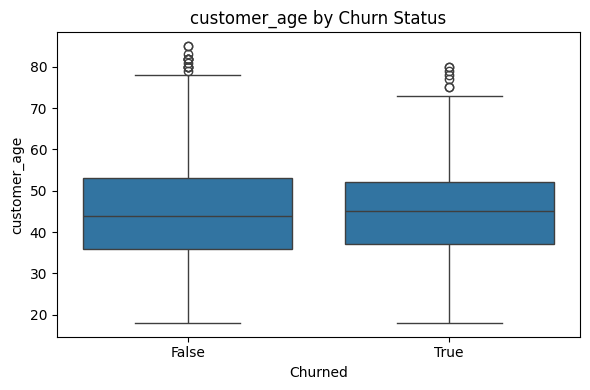

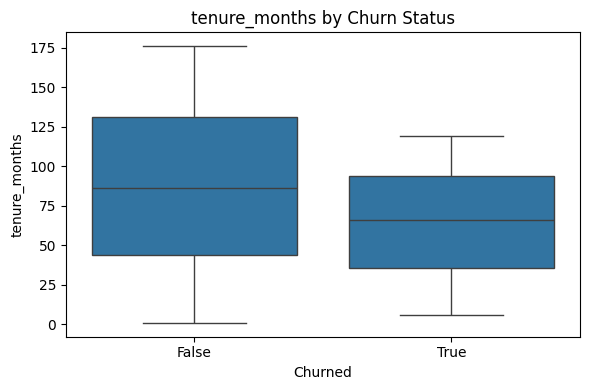

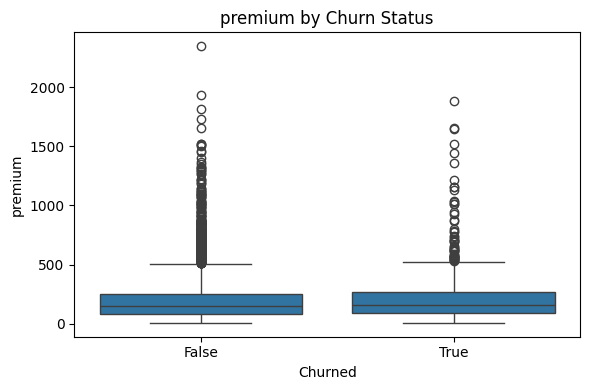

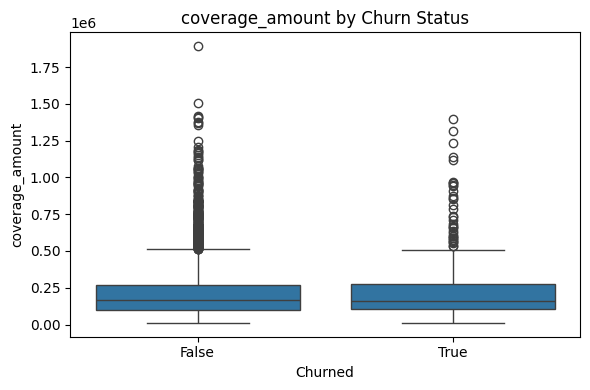

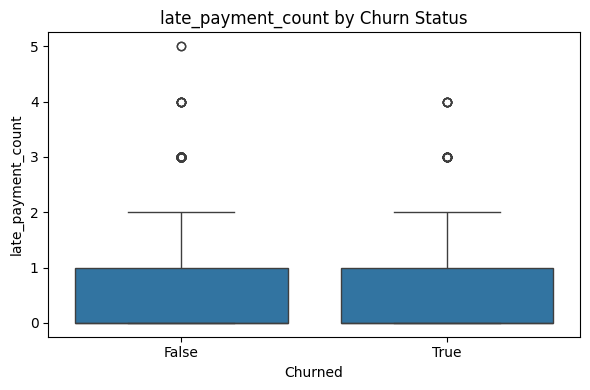

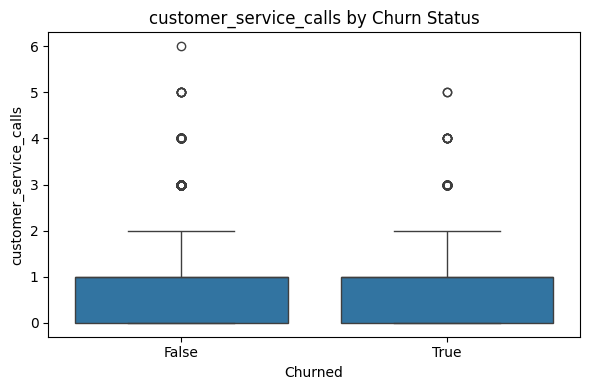

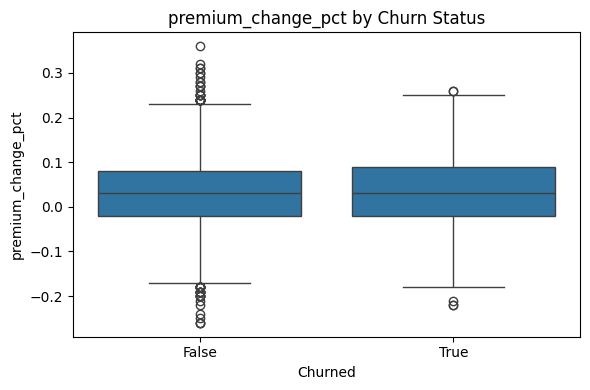

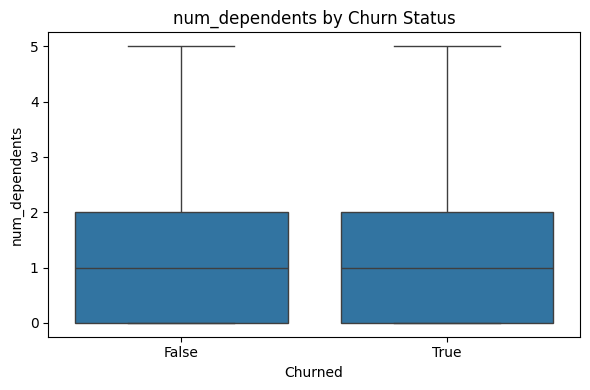

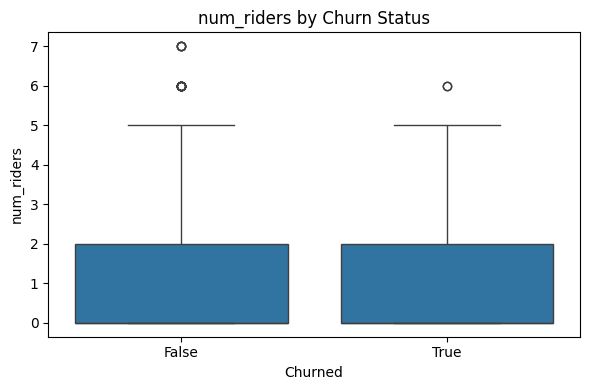

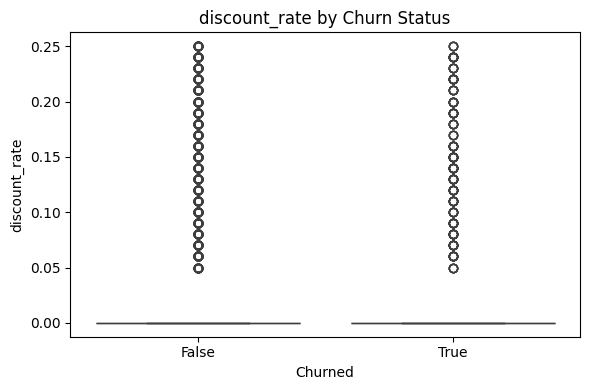

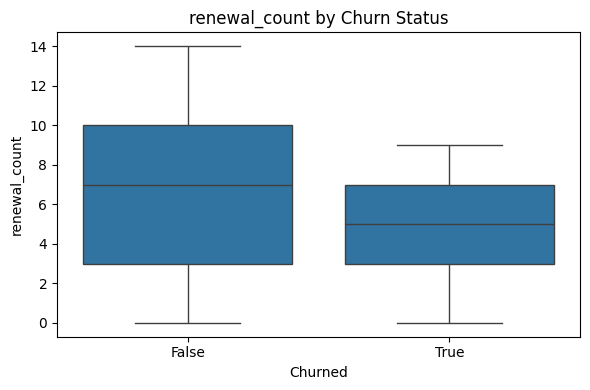

In [23]:
num_cols = [
    'customer_age', 'tenure_months', 'premium',
    'coverage_amount', 'late_payment_count',
    'customer_service_calls', 'premium_change_pct',
    'num_dependents', 'num_riders', 'discount_rate',
    'renewal_count'
]


for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(
        data=policies,
        x='churned',
        y=col
    )
    plt.title(f'{col} by Churn Status')
    plt.xlabel('Churned')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

Which policy or customer characteristics are most associated with churn? - By far, the most indicitive is the payment by month. aqusition channel through the bank also seems like a red flag, especially compared to with and agent. A whole product type also seem to have a significnt rate against Term product. renewal counts also seem to have an effect - more frequanet renewal count seem to have lower churc rates.

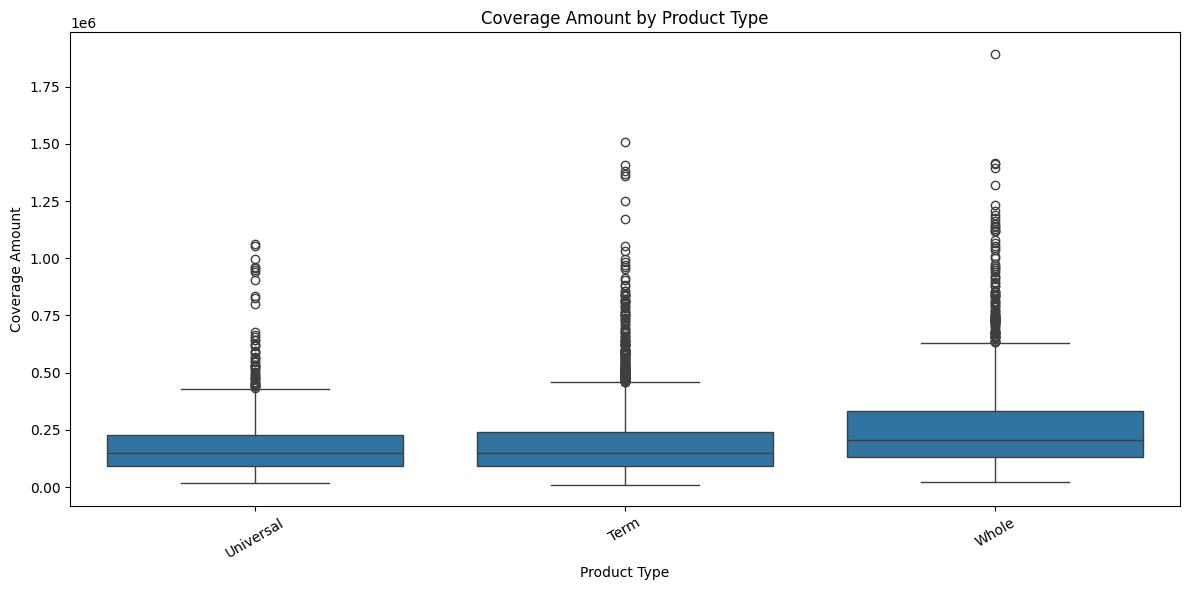

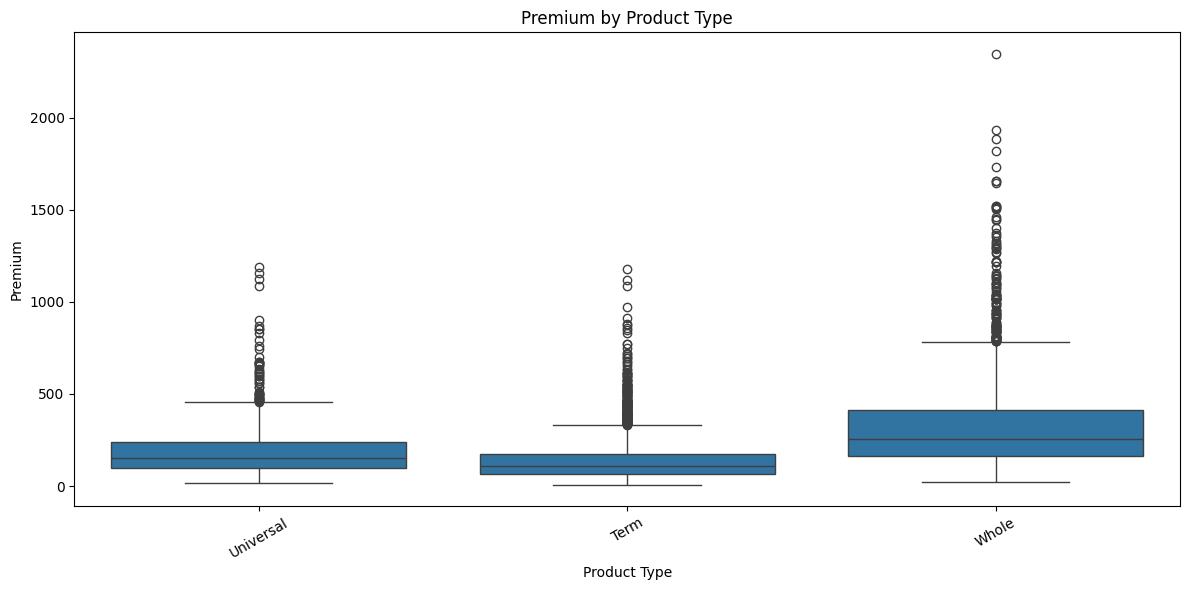

In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=policies,
    x='product_type',
    y='coverage_amount'
)

plt.title('Coverage Amount by Product Type')
plt.xlabel('Product Type')
plt.ylabel('Coverage Amount')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=policies,
    x='product_type',
    y='premium'
)

plt.title('Premium by Product Type')
plt.xlabel('Product Type')
plt.ylabel('Premium')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

How does premium vs. coverage behave across product types? A Whole product type has a higher covereage and premium. Term and Univeral look comparable, with Term having a slightly cheaper premium most of the time.

Are there channels or payment methods that look risky or attractive?: To answer the last question - Bank seems risky, agent look great!

What are the 2–3 most important business insights?



*   A policy bought throguh an agent seems to be less risky as oppose to througe a bank
*   Universal product has similer churn rate to whole products, but is much cheaper premium. maybe we can market the whole product better and sell more from it as oppose to universal

*   look into the payment period - monthly payments casuse higher churn rate - shall we remove this option, or limit the amount of times it is given



What follow-up analyses or actions would you recommend?


*   see how the product type, payment period interact with income band or country - maybe some countries have regulateries to only pay monthly?  make it harder or more acceciable to purchase throguh a bank?
*   see how often the product types are being sold and for who, who tends to buy throguht a bank? male, female? divorced? old? many channels we can see the weak points

Suggest 2–3 features you would engineer for a churn model and explain why.


*   interactions with product type with martial status, country or channel - it can help explain how the effect changes throhge the customer type
*   have a renewal count with age - see the effect of if throguth time, new customer who will just now buy the life premium since he got older for example - to take that into account




